In [2]:
import pandas as pd
import numpy as np


# EXPLORATION DES DONNEES

In [3]:
df = pd.read_csv("cardio_train.csv",sep=";")

df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# Conversion de l'âge en années
df["age"] = (df["age"] / 365).round(0).astype(int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0


### Idenfifier la target
Ma variables cible est : cardio

In [5]:
# dimension
df.shape

(70000, 13)

In [6]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [7]:
df=df.drop('id',axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


### VISUALISATION

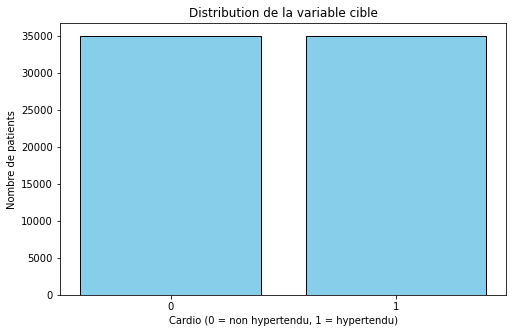

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
bins = [-0.5, 0.5, 1.5]

plt.hist(df['cardio'], bins=bins, color='skyblue', edgecolor='black', rwidth=0.8)
plt.xticks([0, 1])  # s'assurer que seuls 0 et 1 apparaissent sur l'axe X
plt.title("Distribution de la variable cible")
plt.xlabel("Cardio (0 = non hypertendu, 1 = hypertendu)")
plt.ylabel("Nombre de patients")
plt.show()




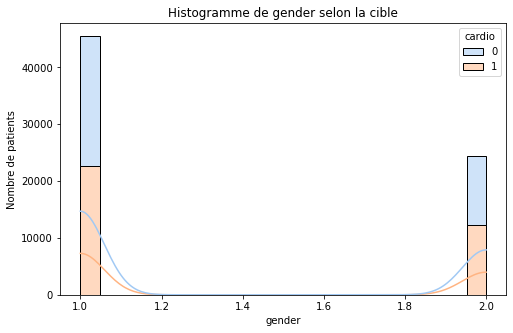

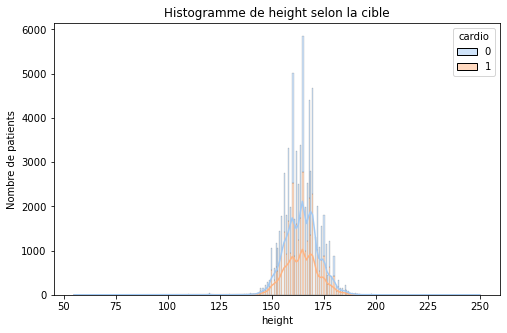

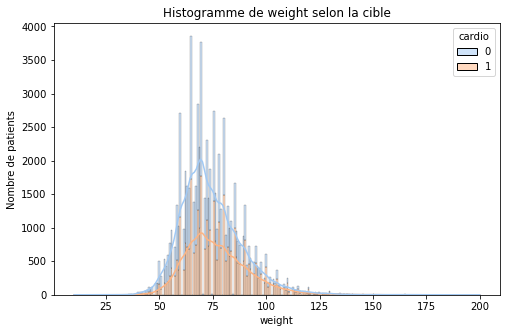

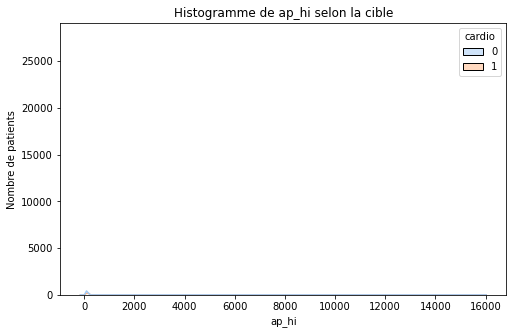

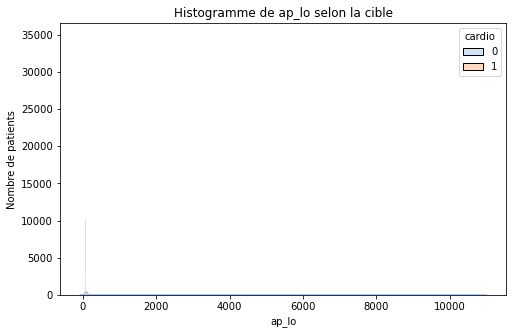

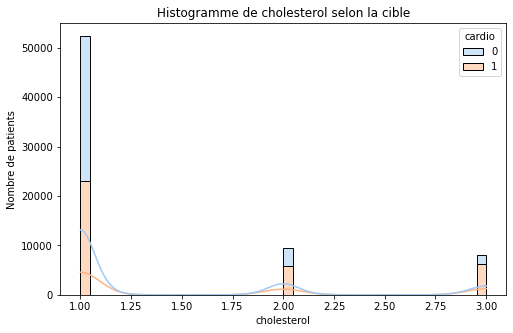

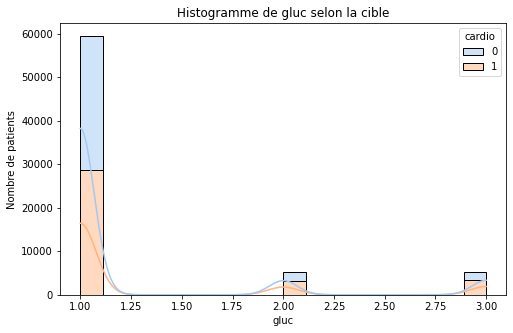

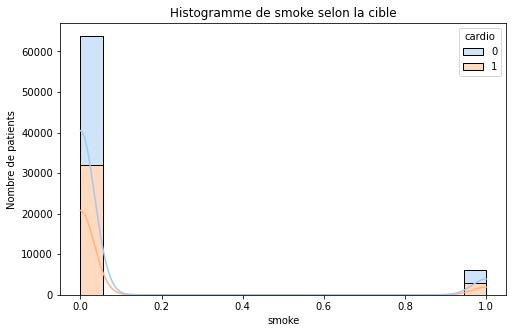

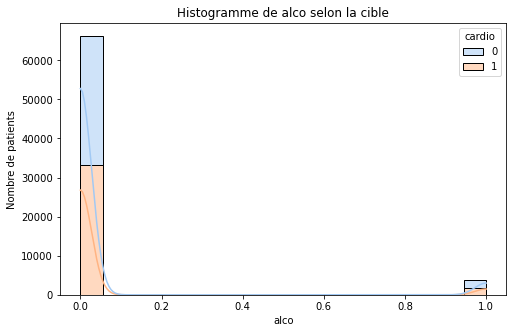

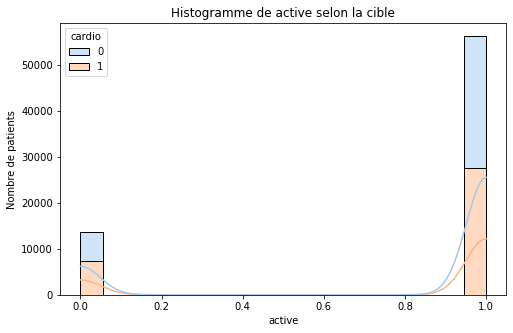

In [9]:

import seaborn as sns

# Sélectionner les features numériques (sauf la target)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('cardio')  # enlever la cible

# Boucle pour générer les histogrammes
for feature in numeric_features:
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x=feature, hue='cardio', kde=True, palette="pastel", multiple="stack")
    plt.title(f"Histogramme de {feature} selon la cible")
    plt.xlabel(feature)
    plt.ylabel("Nombre de patients")
    plt.show()


In [10]:
from scipy import stats

for feature in numeric_features:
    z_scores = stats.zscore(df[feature])
    outliers = df[abs(z_scores) > 3]  # z > 3 ou < -3
    print(f"{feature} : {len(outliers)} outliers détectés par Z-score")


gender : 0 outliers détectés par Z-score
height : 293 outliers détectés par Z-score
weight : 702 outliers détectés par Z-score
ap_hi : 38 outliers détectés par Z-score
ap_lo : 951 outliers détectés par Z-score
cholesterol : 0 outliers détectés par Z-score
gluc : 5331 outliers détectés par Z-score
smoke : 6169 outliers détectés par Z-score
alco : 3764 outliers détectés par Z-score
active : 0 outliers détectés par Z-score


# PREPROCESSING

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
# Créer la colonne BMI
df["BMI"] = df["weight"] / (df["height"]/100)**2

# Filtrer les valeurs aberrantes (optionnel mais recommandé)
df = df[(df["ap_hi"] >= 80) & (df["ap_hi"] <= 240)]
df = df[(df["ap_lo"] >= 50) & (df["ap_lo"] <= 150)]
df = df[(df["weight"] >= 30) & (df["weight"] <= 200)]
df = df[(df["height"] >= 140) & (df["height"] <= 210)]

# Séparer features et target
X = df.drop(columns=[ "cardio"])
y = df["cardio"]

# Split train/test/validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardisation des features numériques
num_features = ["age", "height", "weight", "ap_hi", "ap_lo", "BMI"]
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


# MODELLING

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Fonction d'évaluation
def evaluate_model(model, X_val, y_val, X_test, y_test):
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    print(f"Performance sur le val set :")
    print("Accuracy :", accuracy_score(y_val, y_val_pred))
    print("F1-score :", f1_score(y_val, y_val_pred))
    print("\nPerformance finale sur le test set :")
    print("Accuracy :", accuracy_score(y_test, y_test_pred))
    print("F1-score :", f1_score(y_test, y_test_pred))
    print("\nClassification report :\n", classification_report(y_test, y_test_pred))

# Modèles
models = {
    "LogisticRegression": LogisticRegression(solver='liblinear', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Entraînement et évaluation
for name, model in models.items():
    print(f"--- Évaluation du modèle : {name} ---")
    model.fit(X_train, y_train)
    evaluate_model(model, X_val, y_val, X_test, y_test)


--- Évaluation du modèle : LogisticRegression ---
Performance sur le val set :
Accuracy : 0.7257170636849781
F1-score : 0.7092651757188498

Performance finale sur le test set :
Accuracy : 0.7264242659926113
F1-score : 0.7094775965310758

Classification report :
               precision    recall  f1-score   support

           0       0.71      0.78      0.74      5195
           1       0.75      0.67      0.71      5091

    accuracy                           0.73     10286
   macro avg       0.73      0.73      0.73     10286
weighted avg       0.73      0.73      0.73     10286

--- Évaluation du modèle : RandomForest ---
Performance sur le val set :
Accuracy : 0.6995624696159456
F1-score : 0.6977108198004304

Performance finale sur le test set :
Accuracy : 0.7166050943029361
F1-score : 0.713344478316452

Classification report :
               precision    recall  f1-score   support

           0       0.72      0.72      0.72      5195
           1       0.71      0.71      0.71  

c:\Users\HP Pavilion\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [05:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance sur le val set :
Accuracy : 0.7302868254739913
F1-score : 0.7199676963456492

Performance finale sur le test set :
Accuracy : 0.7346879253354074
F1-score : 0.7229722870774541

Classification report :
               precision    recall  f1-score   support

           0       0.72      0.77      0.75      5195
           1       0.75      0.70      0.72      5091

    accuracy                           0.73     10286
   macro avg       0.74      0.73      0.73     10286
weighted avg       0.74      0.73      0.73     10286



### CRIDSEARCH_CV

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
evaluate_model(best_xgb, X_val, y_val, X_test, y_test)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\HP Pavilion\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [05:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Performance sur le val set :
Accuracy : 0.7342732134175984
F1-score : 0.7221713937175968

Performance finale sur le test set :
Accuracy : 0.7382850476375656
F1-score : 0.726144455747711

Classification report :
               precision    recall  f1-score   support

           0       0.73      0.77      0.75      5195
           1       0.75      0.70      0.73      5091

    accuracy                           0.74     10286
   macro avg       0.74      0.74      0.74     10286
weighted avg       0.74      0.74      0.74     10286



In [15]:
import pandas as pd

# Ordre des features utilisé dans ton modèle (doit correspondre à X_train)
feature_order = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'BMI']
scaler_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']

# Profils patients
patient_healthy = {
    'age': 70,
    'gender': 1,
    'height': 170,
    'weight': 75,
    'ap_hi': 120,
    'ap_lo': 80,
    'cholesterol': 1,
    'gluc': 1,
    'smoke': 0,
    'alco': 0,
    'active': 1,
    'BMI': 75 / (1.70**2)
}

patient_risk = {
    'age': 70,
    'gender': 1,
    'height': 170,
    'weight': 120,
    'ap_hi': 180,
    'ap_lo': 110,
    'cholesterol': 3,
    'gluc': 3,
    'smoke': 1,
    'alco': 1,
    'active': 0,
    'BMI': 120 / (1.70**2)
}

# Créer DataFrame avec le bon ordre
df_patients = pd.DataFrame([
    [patient_healthy[col] for col in feature_order],
    [patient_risk[col] for col in feature_order]
], columns=feature_order)

# Standardiser seulement les colonnes numériques
df_patients[scaler_features] = scaler.transform(df_patients[scaler_features])

# Prédictions
pred_class = best_xgb.predict(df_patients)
# Probabilités prédites pour nos patients
pred_proba = best_xgb.predict_proba(df_patients)

# Choisir un seuil personnalisé, par exemple 0.65
threshold = 0.65

# Classe prédite selon le seuil
pred_class_custom = (pred_proba[:, 1] >= threshold).astype(int)

# Affichage
for i, patient_name in enumerate(['Sain', 'À risque']):
    print(f"\nProfil {patient_name} :")
    print("Classe prédite (seuil 0.65) :", pred_class_custom[i])
    print("Probabilité d'hypertension :", pred_proba[i])




Profil Sain :
Classe prédite (seuil 0.65) : 0
Probabilité d'hypertension : [0.3830126 0.6169874]

Profil À risque :
Classe prédite (seuil 0.65) : 1
Probabilité d'hypertension : [0.15896243 0.8410376 ]


In [16]:
# Sauvegarde du modèle 
import joblib
joblib.dump(best_xgb,'model.pkl')
joblib.dump(scaler,"scaler.pkl")

['scaler.pkl']

### LEARNING CURVE ET DECISION FINAL

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np

In [18]:
train_size , train_score, test_score = learning_curve (

    estimator=best_xgb,
    X= X_train,
    y= y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1,1.0,10),
    n_jobs=1
)

c:\Users\HP Pavilion\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [05:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HP Pavilion\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [05:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HP Pavilion\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [05:15:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\HP Pavilion\anac

In [19]:
train_mean = train_score.mean(axis=1)
train_std = train_score.std(axis=1)

test_mean = test_score.mean(axis=1)
test_std = test_score.std(axis=1)


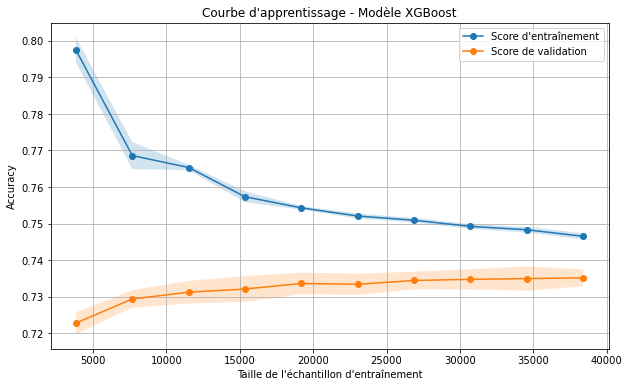

In [20]:
plt.figure(figsize=(10,6))
plt.plot(train_size, train_mean, 'o-', label="Score d'entraînement")
plt.plot(train_size, test_mean, 'o-', label="Score de validation")

# Zones d'incertitude (écart-type)
plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, alpha=0.2)

plt.title("Courbe d'apprentissage - Modèle XGBoost")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# PRISE DE DECISION

| Probabilité prédite | Décision médicale           | Explication                                                                 |
|-------------------|----------------------------|---------------------------------------------------------------------------|
| **P < 0.30**       | Patient sain               | Aucun signe d’hypertension, simple suivi normal                           |
| 0.30 ≤ P < 0.65    | Surveiller (risque modéré) | Recommandations : perte de poids, activité, vérifier la tension chaque mois |
| **P ≥ 0.65**       | Patient à haut risque      | Doit être orienté pour dépistage + mesures préventives                     |
